In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine # Needed for DB connection
from sqlalchemy import types
from configparser import ConfigParser

In [2]:
def establish_connection():
    config = ConfigParser()
    config.read('config.ini')

    # Database settings
    driver = config.get('main', 'driver')
    username = config.get('main', 'username')
    dbname = config.get('main', 'dbname')
    password = config.get('main', 'password')
    server = config.get('main', 'server')
    port = config.get('main', 'port')

    # Creating the connection pool for SQL
    return create_engine(f'{driver}://{username}:{password}@{server}:{port}/{dbname}')

In [21]:
def get_data(engine, table):
    with engine.connect() as conn:
        return pd.DataFrame(conn.execute('SELECT * FROM project.'+table).all())

In [24]:
engine = establish_connection()

# Load tables
match = get_data(engine, 'match')
team = get_data(engine, 'team')
team_stats = get_data(engine, 'team_stats')
penalty = get_data(engine, 'penalty')

In [87]:
columns_to_loop = team_stats.columns[2:]
correlations = pd.DataFrame() 

# Loop all the colum
for column in columns_to_loop:
    for column_compare in columns_to_loop:
        # Check if it's already present or it's the same column
        if((column != column_compare) & ((column_compare+" and "+column) not in correlations.columns)):
            # Retrieve the data 
            pair = team_stats.loc[(team_stats[column] >= 0) & (team_stats[column_compare] >= 0)]
            
            # Transform the data to numpy arrays
            first_list = pair[column].to_numpy()
            second_list = pair[column_compare].to_numpy()
            # Compute the Pearson correlation between the retrieved columns
            correlations[column+" and "+column_compare] = pearsonr(first_list, second_list)


In [90]:
import csv
# Order the correlations
ordered_correlations = correlations.iloc[0].sort_values(ascending=False)

# Save the correlation to file
ordered_correlations.to_csv('pearson_corr.csv', header=False)

# Print the correlations
print(ordered_correlations)

score and shots_on_target            0.682100
score and shots                      0.610071
shots and shots_on_target            0.523933
shots_on_target and shot_accuracy    0.494982
possession and pass_accuracy         0.454839
shots_on_target and corners          0.404582
possession and shot_accuracy         0.376229
score and possession                 0.320096
shots_on_target and possession       0.316525
shots and tackles                    0.309325
shots and shot_accuracy              0.291108
score and shot_accuracy              0.285546
shot_accuracy and pass_accuracy      0.255927
shots_on_target and tackles          0.243490
tackles and corners                  0.234937
shots and possession                 0.199089
tackles and fouls                    0.190037
score and pass_accuracy              0.189888
shots_on_target and pass_accuracy    0.176083
shots_on_target and fouls            0.152439
tackles and shot_accuracy            0.149533
shots and corners                 

36

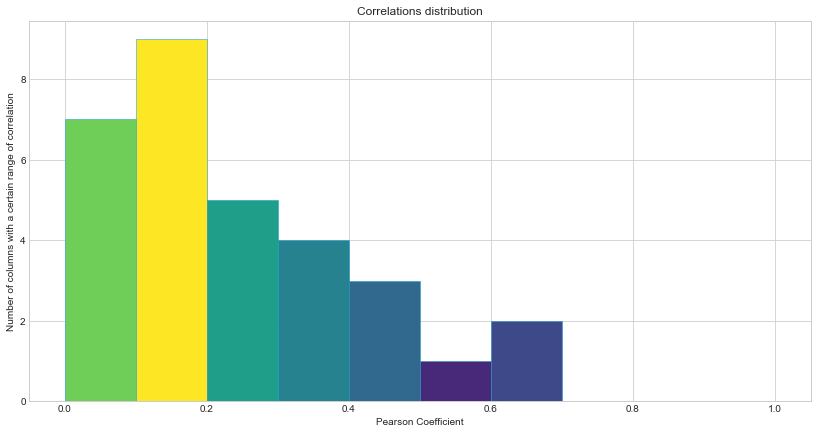

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid')
n, bins, patches = plt.hist(ordered_correlations, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

# Adds colors to the plot depending on the intensity
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Add annotation
plt.title('Correlations distribution') 
plt.xlabel('Pearson Coefficient') 
plt.ylabel('Number of columns with a certain range of correlation') 
plt.show()